## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()

## And so on and so forth...

In [2]:
import pickle

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
cal_pickle = {}
cal_pickle["mtx"] = mtx
cal_pickle["dist"] = dist
pickle.dump(cal_pickle, open("cal_pickle.p", "wb"))

In [3]:
import os
os.listdir("test_images/")

['test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg',
 'test7.jpg',
 'test8.jpg']

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def undistort(img):
    # Use cv2.undistort()
    cal_pickle = pickle.load(open("cal_pickle.p", "rb"))
    mtx = cal_pickle["mtx"]
    dist= cal_pickle["dist"]
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def warper(img):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    offset = 100
    src = np.float32([[550,470],[750,470],[1250,750],[100,750]])
    dst = np.float32([[320, 0], [980, 0], [980, 720], [320, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  # keep same size as input image
    #unwarped = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv


def sobel_thresh(img, sobel_kernel=3, sx_thresh=(0, 255)):
    gray = grayscale(img)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sx_binary = np.zeros_like(scaled_sobelx)
    sx_binary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    return sx_binary

def mag_thresh(img, sobel_kernel=9, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = grayscale(img)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(grad_mag)/255
    grad_mag = (grad_mag/scale_factor).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(grad_mag)
    # 6) Return this mask as your binary_output image
    mag_binary[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    return mag_binary

def dir_thresh(img, sobel_kernel=15, dir_thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = grayscale(img)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(absgraddir)
    # 6) Return this mask as your binary_output image
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    return dir_binary

def hls_select(img, s_thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    # 3) Return a binary image of threshold result
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary


In [ ]:
images = glob.glob('../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
d = 1

for fname in images:
    img = cv2.imread(fname)
    undist = undistort(img)
    filename = "../CarND-Advanced-Lane-Lines/output_images/undist_calibration%d.jpg"%d
    cv2.imwrite(filename, undist)
    d+=1

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
images = glob.glob('test_images/test*.jpg')
d = 1

for fname in images:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undist = undistort(img)
    src_array = np.array([[550,470],[750,470],[1250,750],[100,750]])
    cv2.polylines(undist, [src_array], True, (255, 0, 0), 5)
    filename = "../CarND-Advanced-Lane-Lines/output_images/undist_test%d.jpg"%d
    cv2.imwrite(filename, cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    d+=1

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
def image_process(img):
    undist = gaussian_blur(undistort(img), kernel_size=5)
    sx_binary = sobel_thresh(undist, sobel_kernel=3, sx_thresh=(20, 100))
    mag_binary = mag_thresh(undist, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_thresh(undist, sobel_kernel=15, dir_thresh=(0.7, 1.3))
    s_binary = hls_select(undist, s_thresh=(90, 255))
    
    color_binary = np.dstack((sx_binary, s_binary, mag_binary)) * 255
    
    combined = np.zeros_like(dir_binary)
    combined[(sx_binary == 1) | (s_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    warped, _ = warper(undist)
    warped_thresh, Minv = warper(combined)
    
    return undist, sx_binary, mag_binary, dir_binary, s_binary, color_binary, combined, warped, warped_thresh, Minv
    

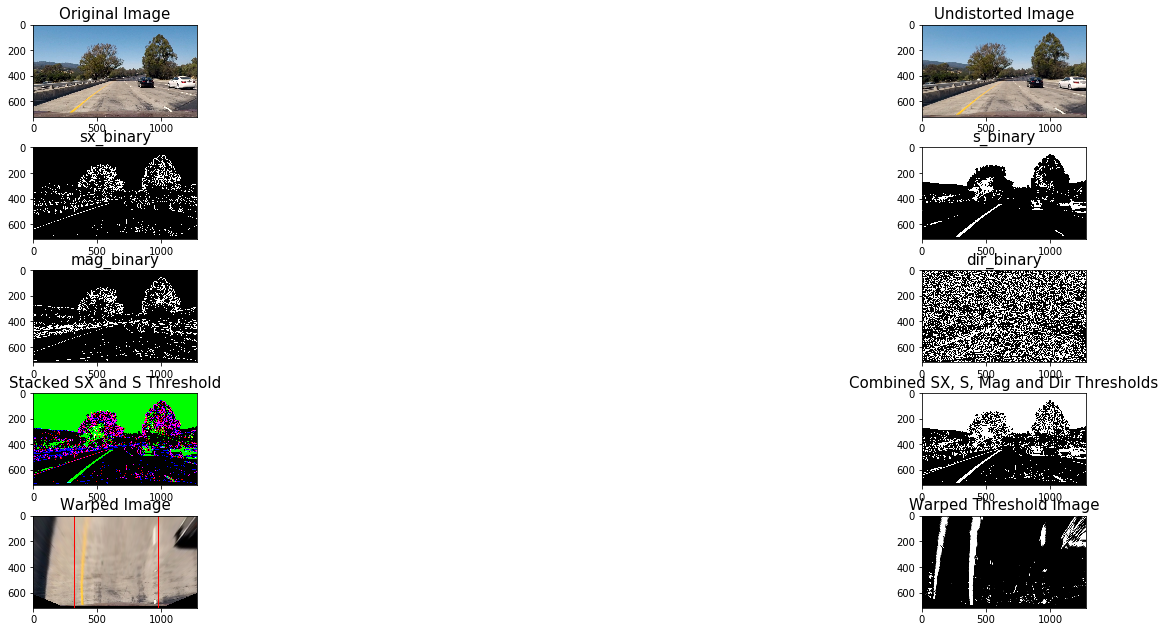

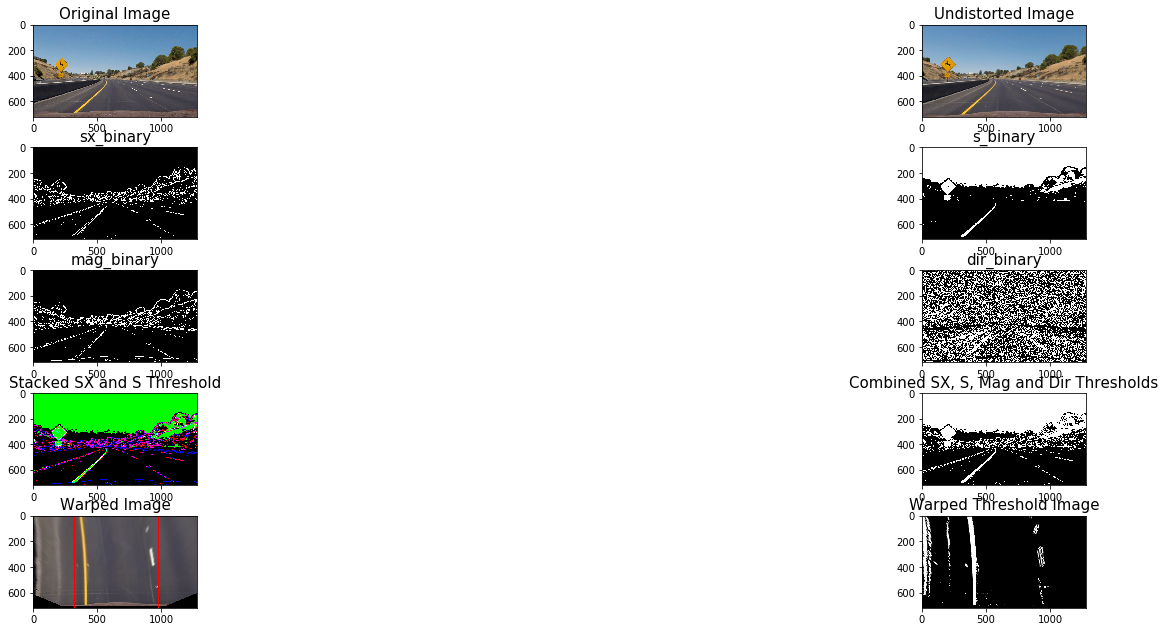

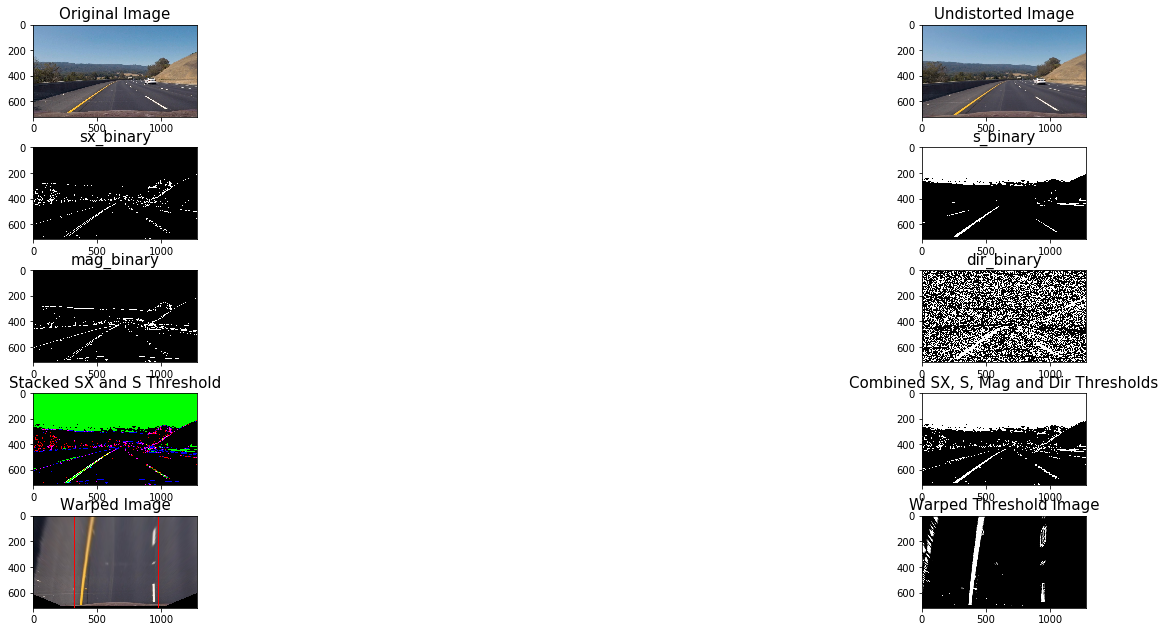

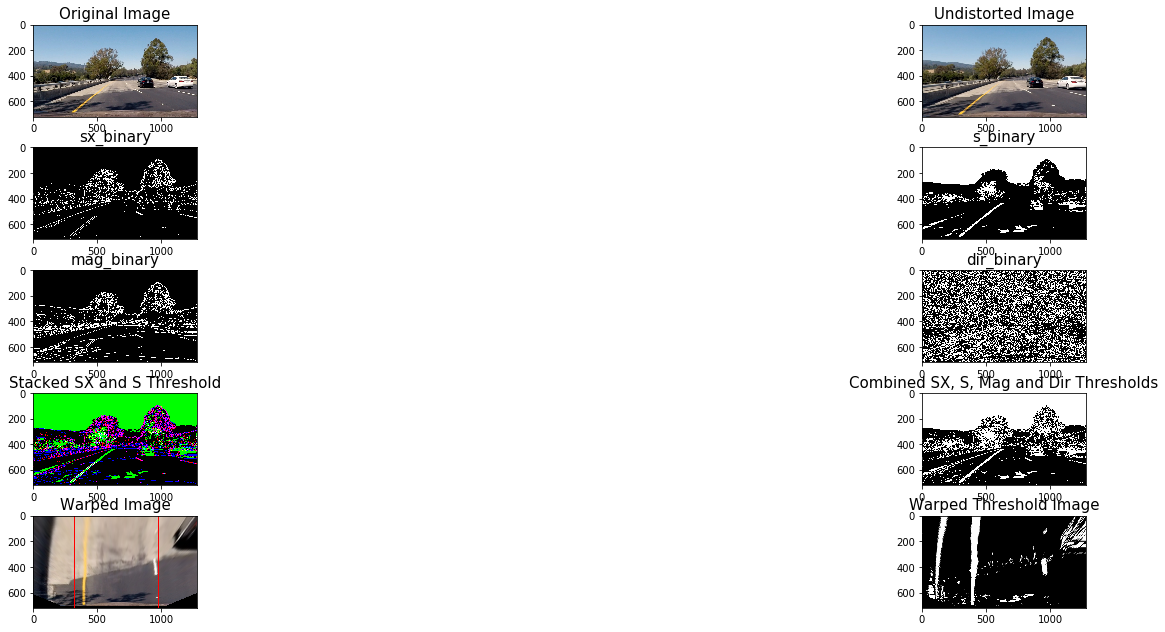

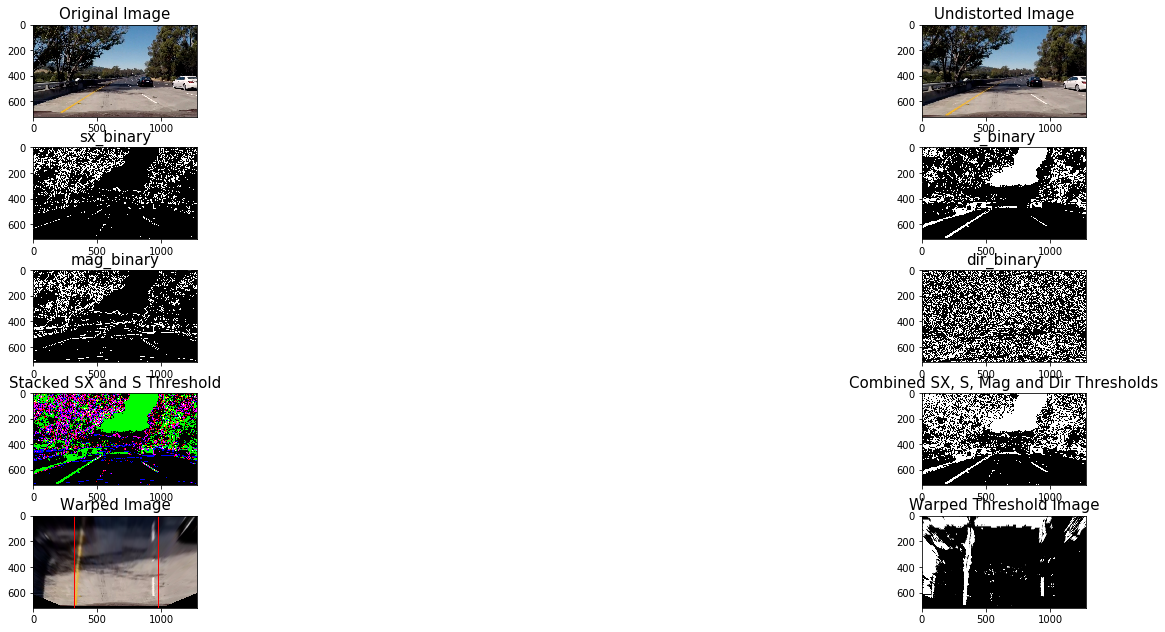

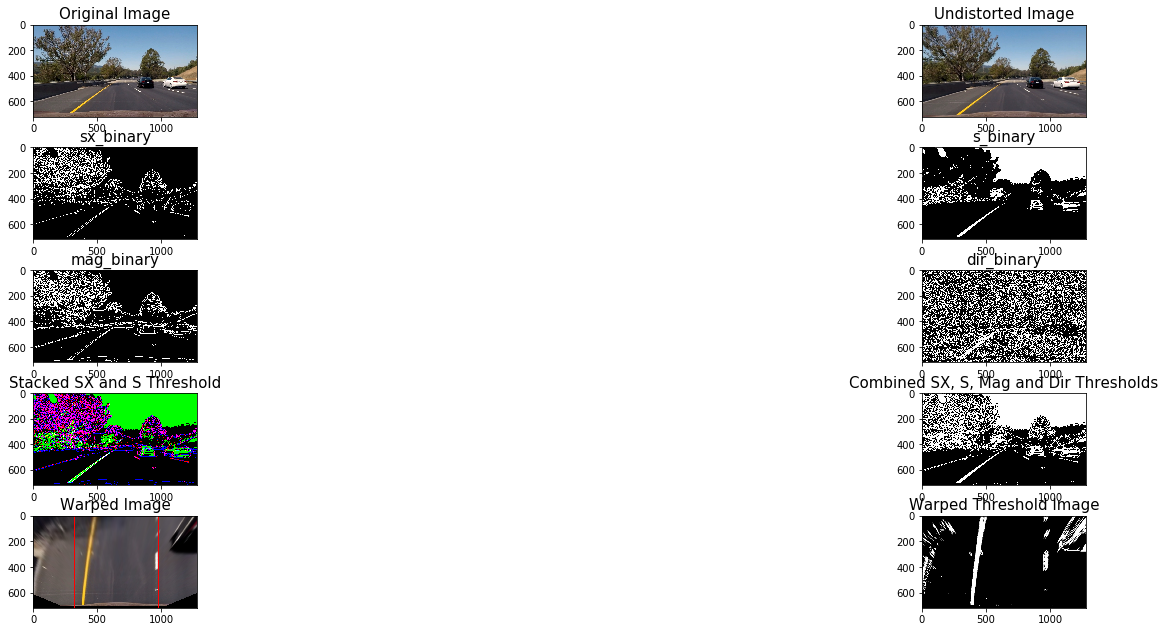

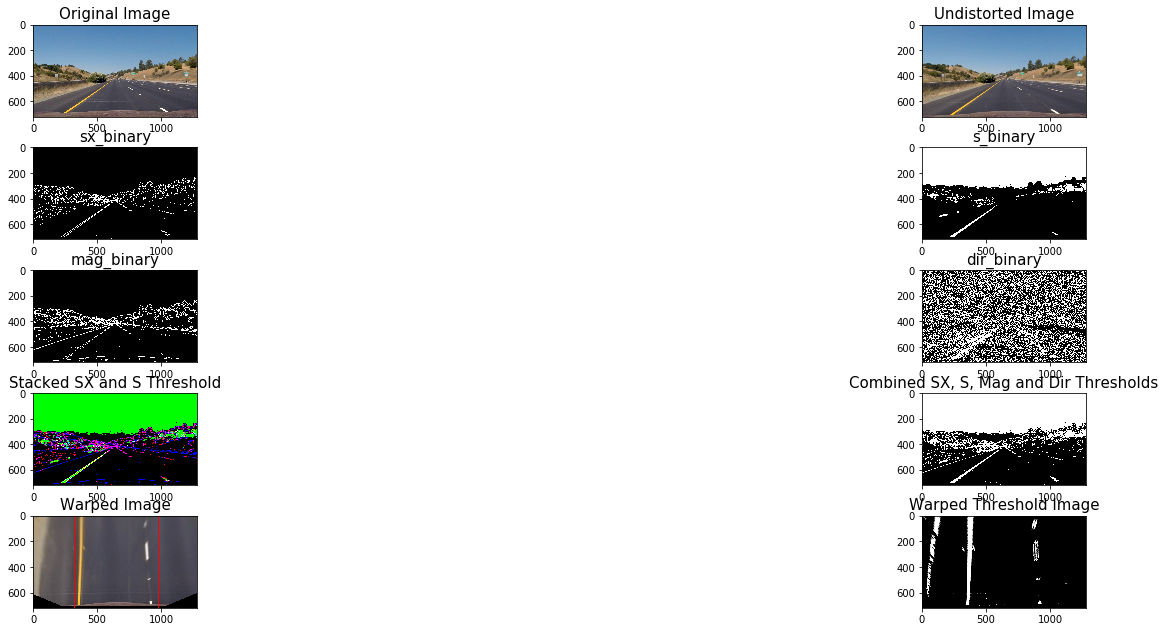

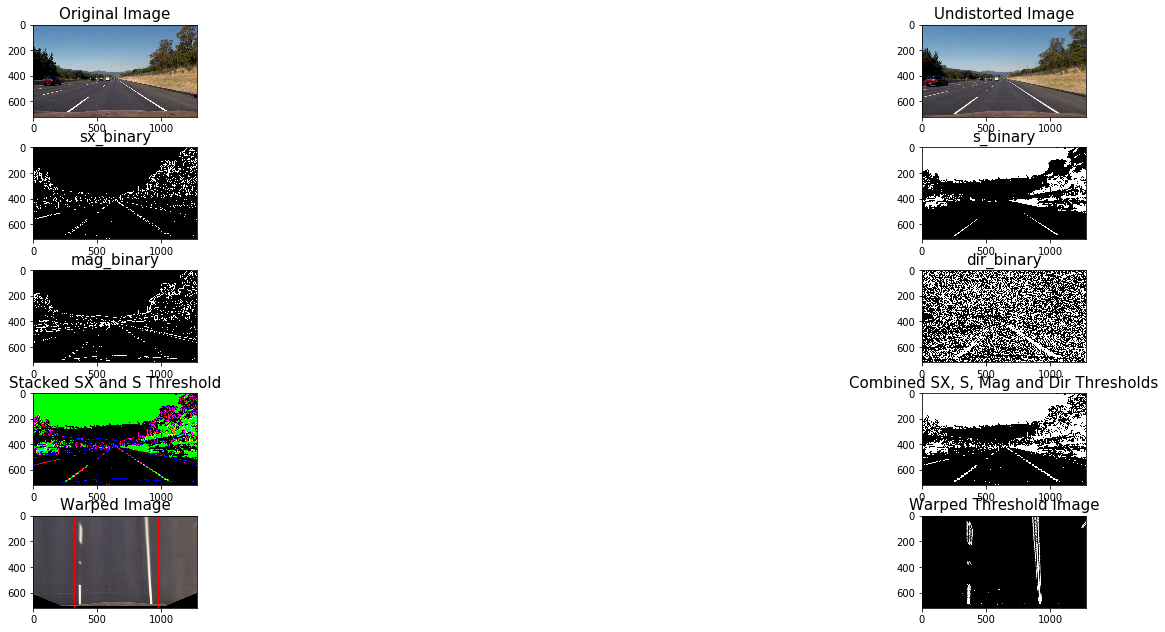

In [8]:
d = 1

for fname in images:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undist, sx_binary, mag_binary, dir_binary, s_binary, color_binary, combined, warped, warped_thresh, Minv = image_process(img)
    dst_array = np.array([[320, 0], [980, 0], [980, 720], [320, 720]])
    cv2.polylines(warped, [dst_array], True, (255, 0, 0), 5)
    filename_sxbinary = "../CarND-Advanced-Lane-Lines/output_images/sxbinary_test%d.jpg"%d
    cv2.imwrite(filename_sxbinary, sx_binary)
    filename_magbinary = "../CarND-Advanced-Lane-Lines/output_images/magbinary_test%d.jpg"%d
    cv2.imwrite(filename_magbinary, mag_binary)
    filename_dirbinary = "../CarND-Advanced-Lane-Lines/output_images/dirbinary_test%d.jpg"%d
    cv2.imwrite(filename_dirbinary, dir_binary)
    filename_sbinary = "../CarND-Advanced-Lane-Lines/output_images/sbinary_test%d.jpg"%d
    cv2.imwrite(filename_sbinary, s_binary) 
    filename_colorbinary = "../CarND-Advanced-Lane-Lines/output_images/colorbinary_test%d.jpg"%d
    cv2.imwrite(filename_colorbinary, cv2.cvtColor(color_binary, cv2.COLOR_BGR2RGB))
    filename_combined = "../CarND-Advanced-Lane-Lines/output_images/combined_test%d.jpg"%d
    cv2.imwrite(filename_combined, combined)
    filename_warped = "../CarND-Advanced-Lane-Lines/output_images/warped_test%d.jpg"%d
    cv2.imwrite(filename_warped, cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    filename_warpedthresh = "../CarND-Advanced-Lane-Lines/output_images/warpedthresh_test%d.jpg"%d
    cv2.imwrite(filename_warpedthresh, warped_thresh)                                                                                                                                                                                                        
    d+=1

    f, ((ax1, ax2),(ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    ax3.imshow(sx_binary, cmap = 'gray')
    ax3.set_title('sx_binary', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    ax4.imshow(s_binary, cmap = 'gray')
    ax4.set_title('s_binary', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    ax5.imshow(mag_binary, cmap = 'gray')
    ax5.set_title('mag_binary', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)                                                                                                                              
    ax6.imshow(dir_binary, cmap = 'gray')
    ax6.set_title('dir_binary', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)                                                                                                                              
    ax7.imshow(color_binary)
    ax7.set_title('Stacked SX and S Threshold', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)                                                                                                                              
    ax8.imshow(combined, cmap = 'gray')
    ax8.set_title('Combined SX, S, Mag and Dir Thresholds', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)                                                                                                                              
    ax9.imshow(warped)
    ax9.set_title('Warped Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)                                                                                                                              
    ax10.imshow(warped_thresh, cmap = 'gray')
    ax10.set_title('Warped Threshold Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)                                                                                                                              
                                                                                                                              
                                                                                                                              

In [12]:
def lane_detection(img):
    binary_warped = img
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    return out_img, left_fit, right_fit

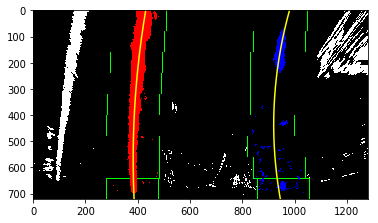

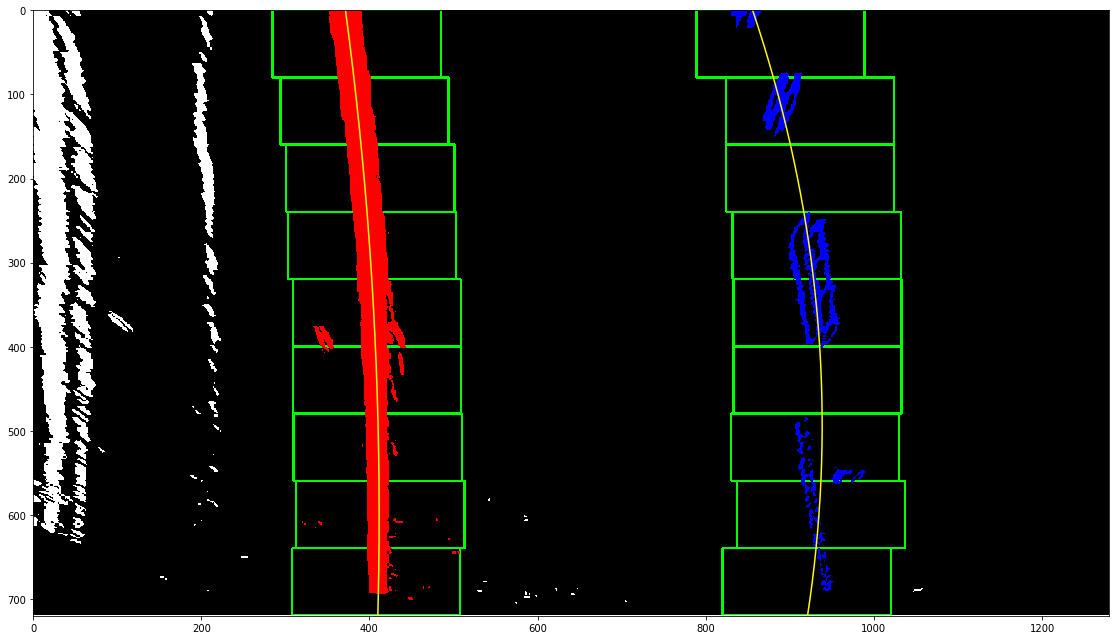

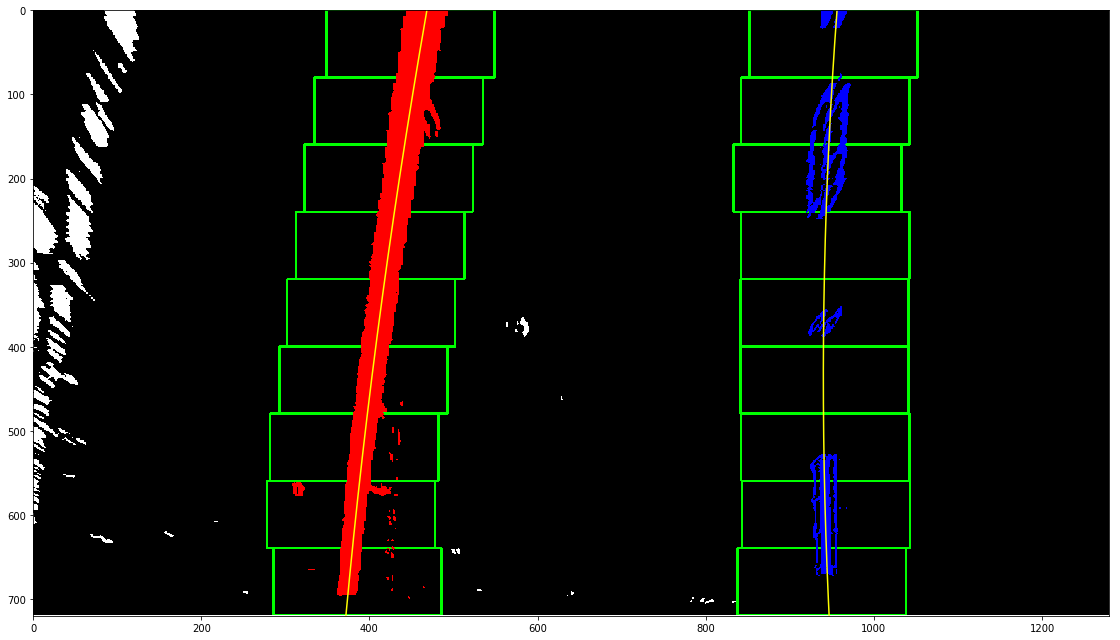

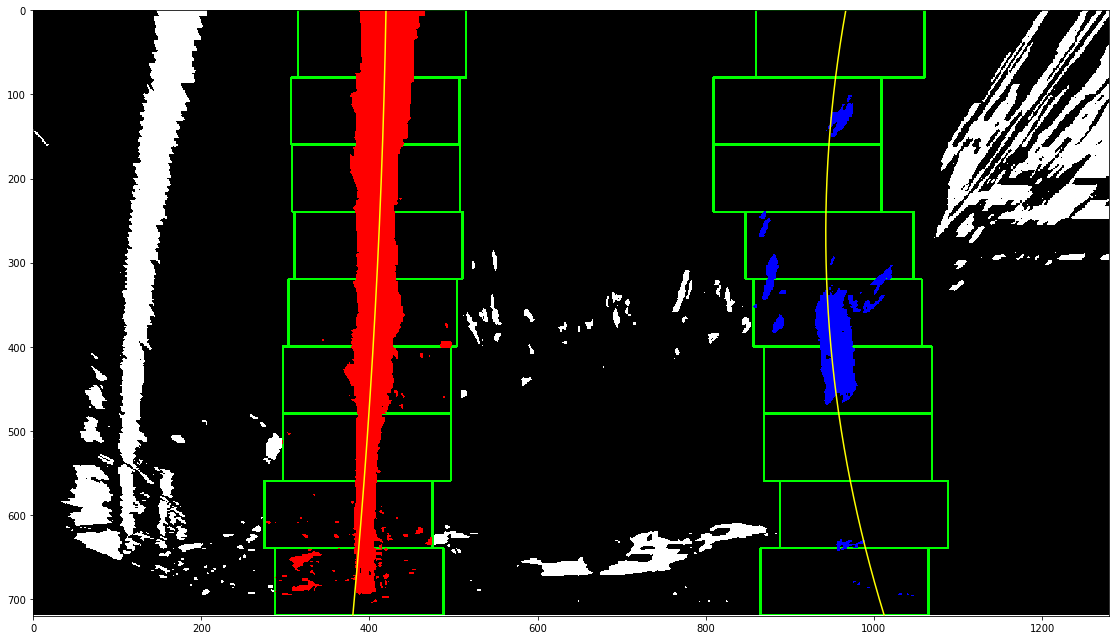

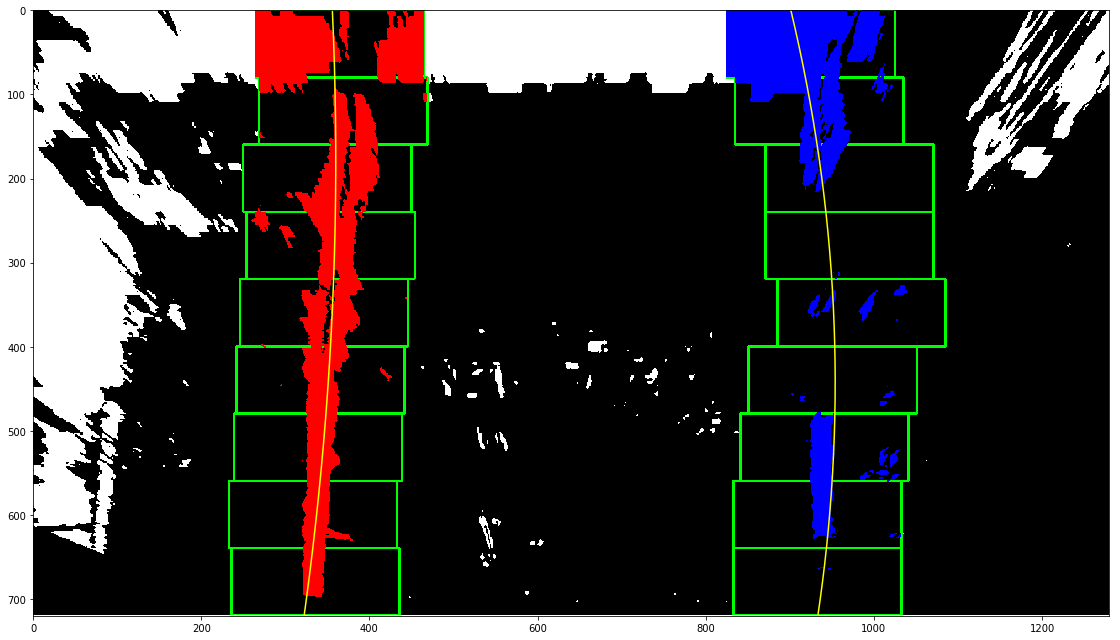

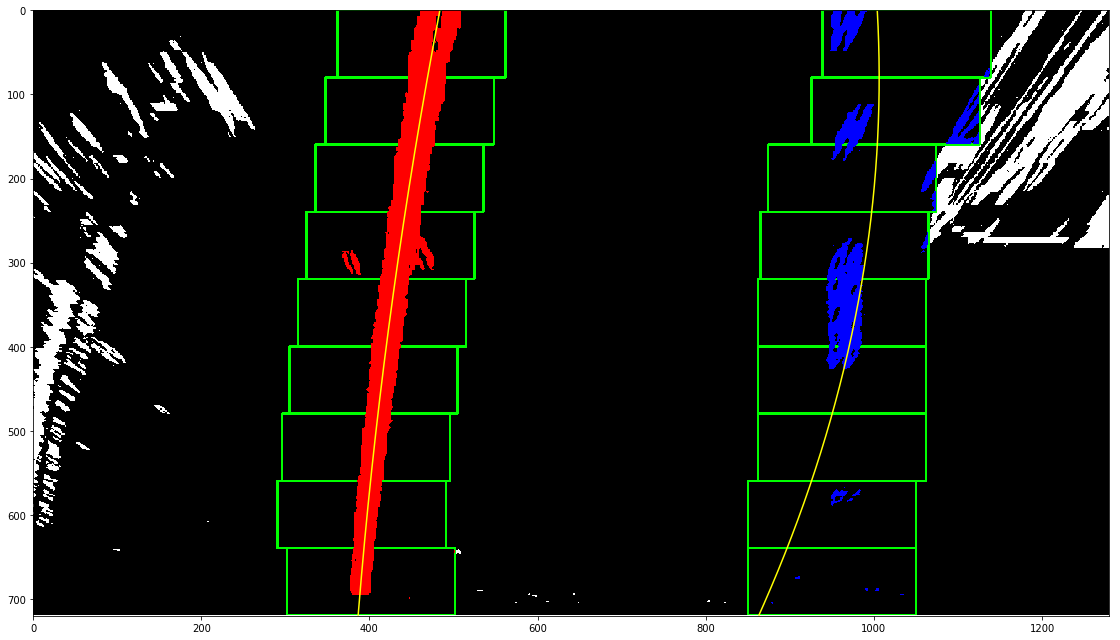

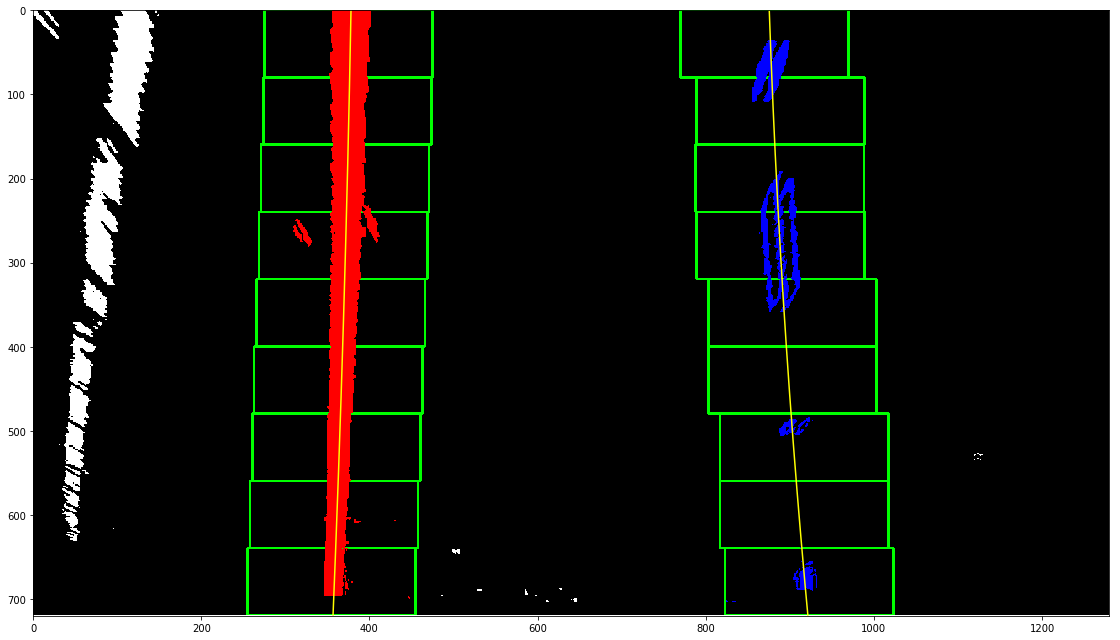

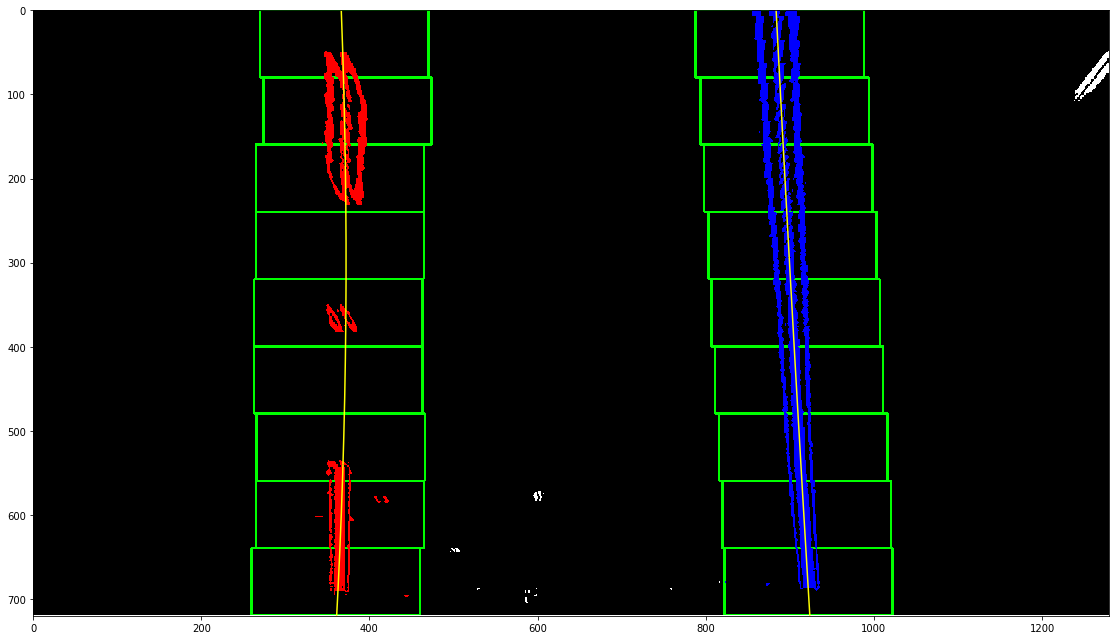

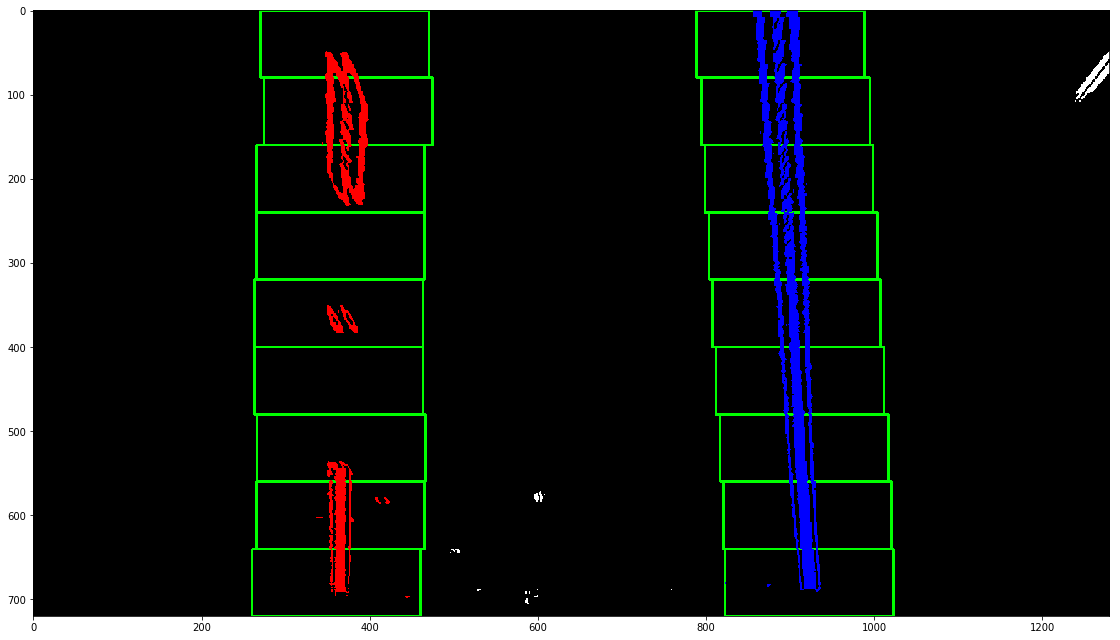

In [11]:
warped_images = glob.glob('../CarND-Advanced-Lane-Lines/output_images/warpedthresh_test*.jpg')
d = 1
for fname in warped_images:
    img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2GRAY)
    out_img, left_fit, right_fit = lane_detection(img)
    filename_outimg = "../CarND-Advanced-Lane-Lines/output_images/outimg_test%d.jpg"%d
    cv2.imwrite(filename_outimg, out_img)
    d+=1
    
    f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(out_img)


    

In [13]:
def lane_detection_margin(img, left_fit, right_fit):
    binary_warped = img
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    return out_img, left_fit, right_fit

In [17]:
def curvature(img, left_fit, right_fit):# Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #Define left and right lanes in pixels
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
   
    #Calculation of center
    #left_lane and right lane bottom in pixels
    left_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    # Lane center as mid of left and right lane bottom
                            
    lane_center = (left_bottom + right_bottom)/2.
    image_center = img.shape[1]/2.
    center = (lane_center - image_center)*xm_per_pix #Convert to meters
    
    #print(left_curverad, 'm', right_curverad, 'm', center, 'm')
    
    return left_curverad, right_curverad, center

In [16]:
for fname in warped_images:
    img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2GRAY)
    out_img, left_fit, right_fit = lane_detection(img)
    curvature(out_img, left_fit, right_fit)

1105.48509511 m 521.166774283 m 0.34644628418 m
1479.30217568 m 484.112347388 m -0.13957938038 m
2885.34115 m 1921.02997725 m 0.382131521768 m
3169.89862259 m 487.888667151 m 0.281559451424 m
1281.07297816 m 611.481311465 m -0.0608358669085 m
2147.21547042 m 470.977797356 m 0.548764879469 m
10545.3982411 m 4037.39007583 m -0.0695567681181 m
2590.94076085 m 25379.3542181 m -0.0786961326045 m


In [18]:
def add_text_to_image(img, left_cur, right_cur, center):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param img:
    """
    cur = (left_cur + right_cur)/2.

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % cur, (50, 50), font, 1, (255, 255, 255), 2)

    left_or_right = "left" if center < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(center), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)

In [19]:
def draw_lines(undist, warped_thresh, left_fit, right_fit, left_curverad, right_curverad, center):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_thresh).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped_thresh.shape[0]-1, warped_thresh.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    add_text_to_image(result, left_curverad, right_curverad, center)
    plt.imshow(result)
    
    return result

In [ ]:
d=1
for fname in images:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undist, sx_binary, mag_binary, dir_binary, s_binary, color_binary, combined, warped, warped_thresh, Minv = image_process(img)
    out_img, left_fit, right_fit = lane_detection(warped_thresh)
    left_curverad, right_curverad, center = curvature(out_img, left_fit, right_fit)
    result = draw_lines(undist, warped_thresh, left_fit, right_fit, left_curverad, right_curverad, center)
    filename_result = "../CarND-Advanced-Lane-Lines/output_images/result_test%d.jpg"%d
    cv2.imwrite(filename_result, cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    d+=1
    f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(result)

In [21]:
def sanity_check(left_fit, right_fit):
    #Performs a sanity check on the lanes

    #1. Check if left and right fit returned a value
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines >= 150 and delta_lines <=430: #apprrox delta in pixels
            status = True
        else:
            status = False
        
        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        L_0 = 2*left_fit[0]*360+left_fit[1]
        R_0 = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(L_0-R_0)
        
         # Calculate slope of left and right lanes at top of y (i.e. 720)
        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        delta_slope_top =  np.abs(L_1-R_1)
        
        #Check if lines are parallel at the middle
        
        if delta_slope_mid<=0.1:
            status = True
        else:
            status = False
            
    return status

In [22]:
def process_image(image):
    global counter
    global last_left 
    global last_right
    global left_fit
    global right_fit
    undist, sx_binary, mag_binary, dir_binary, s_binary, color_binary, combined, warped, warped_thresh, Minv = image_process(image)
    
    if counter ==0:
        out_img, left_fit, right_fit = lane_detection(warped_thresh)
    else:
        out_img, left_fit, right_fit  = lane_detection_margin(warped_thresh, left_fit, right_fit)
        
    # Do Sanity check
    status =sanity_check(left_fit, right_fit)
    
    #Decide if to use calculated points
    if status == True:        
        #Save as last reliable fit
        last_left, last_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = last_left, last_right
        
    
    left_curverad, right_curverad, center = curvature(out_img, left_fit, right_fit)
    
    result = draw_lines(undist, warped_thresh, left_fit, right_fit, left_curverad, right_curverad, center)
    
    return result

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video test_video.mp4
[MoviePy] Writing video test_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:10<00:00,  2.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video.mp4 

Wall time: 9min 12s
621


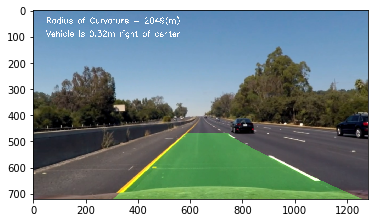

In [25]:
#Create video file pipeline
counter=0
output = 'test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print(counter)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))